### Step1: Load POWER dataset

In [2]:
import pandas as pd
import numpy as np

# Path to power txt file
file_path = 'household_power_consumption.txt'

# Load with ; separator, handle '?' as NaN
data = pd.read_csv(file_path, sep=';', na_values='?')

# Combine Date and Time to datetime
data['datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%d/%m/%Y %H:%M:%S')

# Numerical timestamp: seconds since the earliest date
min_dt = data['datetime'].min()
data['timestamp'] = (data['datetime'] - min_dt).dt.total_seconds()

# Relevant columns (drop Date/Time/datetime, keep numerics)
cols = ['timestamp', 'Global_active_power', 'Global_reactive_power', 'Voltage', 
        'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
data = data[cols].dropna()  # ~1.25% missing, drop for simplicity
full_data_size = len(data)

print(f"Dataset loaded: {data.shape[0]} rows")
print(f"First 5 data: {data.head()}")
print(f"Data size: {full_data_size}")


Dataset loaded: 2049280 rows
First 5 data:    timestamp  Global_active_power  Global_reactive_power  Voltage  \
0        0.0                4.216                  0.418   234.84   
1       60.0                5.360                  0.436   233.63   
2      120.0                5.374                  0.498   233.29   
3      180.0                5.388                  0.502   233.74   
4      240.0                3.666                  0.528   235.68   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
0              18.4             0.0             1.0            17.0  
1              23.0             0.0             1.0            16.0  
2              23.0             0.0             2.0            17.0  
3              23.0             0.0             1.0            17.0  
4              15.8             0.0             1.0            17.0  
Data size: 2049280


### Step2: Create a Small Offline Sample

In [3]:
sample_size = int(0.001 * len(data))
sample = data.sample(n=sample_size, random_state=42).copy()
print(f"Sample created: {sample.shape[0]} rows")
print(sample.head())

Sample created: 2049 rows
          timestamp  Global_active_power  Global_reactive_power  Voltage  \
1030580  61834800.0                1.502                  0.074   240.17   
1815       108900.0                0.374                  0.264   245.50   
1295977  77758620.0                0.620                  0.300   239.85   
206669   12400140.0                0.280                  0.200   235.72   
1048893  62933580.0                1.372                  0.054   243.95   

         Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
1030580               6.4             0.0             0.0            18.0  
1815                  1.8             0.0             2.0             0.0  
1295977               3.0             0.0             1.0             1.0  
206669                1.4             0.0             0.0             0.0  
1048893               5.6             0.0             0.0            18.0  


### Step 3: Generate Query Log, training data, testing data, optimize testing data.

Chapter 6.1: "In order to avoid most of the multi-dimensional query results to be zero, we limit the range to generate the boundaries in each dimension. The left boundary of the range in each dimension is randomly chosen from the first quarter of the entire value range of the corresponding attribute. Similarly, each right boundary is randomly chosen from the last quarter of the corresponding attribute range."

In [4]:
from funcs import generate_random_query, exact_sum, sample_sum

# Define dimensions (7D) and their min/max
dimensions = ['timestamp', 'Global_reactive_power', 'Voltage', 'Global_intensity', 
              'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

q = generate_random_query(data, dimensions, test = True)
print(q)

dim: timestamp, min value: 0.0, max value: 124515480.0
dim: Global_reactive_power, min value: 0.0, max value: 1.39
dim: Voltage, min value: 223.2, max value: 254.15
dim: Global_intensity, min value: 0.2, max value: 48.4
dim: Sub_metering_1, min value: 0.0, max value: 88.0
dim: Sub_metering_2, min value: 0.0, max value: 80.0
dim: Sub_metering_3, min value: 0.0, max value: 31.0
{'timestamp': (24129467.943195876, 121557356.05521038), 'Global_reactive_power': (0.09668449650504118, 1.0444804929585123), 'Voltage': (229.62657129094887, 252.74551851736973), 'Global_intensity': (2.8182107152086755, 46.35012010623028), 'Sub_metering_1': (19.35412475989916, 66.17198394313085), 'Sub_metering_2': (3.6762939143881113, 78.31143024856063), 'Sub_metering_3': (7.514343704143022, 30.674410428249466)}


Build query log, the main task is SUM.

In [5]:
# Aggregate column
agg_col = 'Global_active_power'

# set a avg_exact as threshold
print("Generate avg_exact by temp queries...")
temp_query_log = []
num_queries = 2000
attempts = 0
max_attempts = 10000

while len(temp_query_log) < num_queries and attempts < max_attempts:
    q = generate_random_query(data, dimensions)
    exact_result = exact_sum(agg_col, q, data)
    if exact_result > 1.0:  # the result will propbably be 0, make threshold to 1 to ensure valuable result.
        estimate = sample_sum(agg_col, q, sample, full_data_size)
        error = exact_result - estimate
        temp_query_log.append({'query': q, 'exact': exact_result, 
                          'estimate': estimate, 'error': error})
    attempts += 1

avg_exact = np.mean([temp_query['exact'] for temp_query in temp_query_log])
print(f"Generated {len(temp_query_log)} temp queries in {attempts} attempts")
print(f"Average exact sum: {avg_exact=}\n")

# 2000 query log
query_log = []
attempts = 0
print("Generating 2000 queries...")
while len(query_log) < num_queries and attempts < max_attempts:
    q = generate_random_query(data, dimensions)
    exact_result = exact_sum(agg_col, q, data)
    
    if exact_result > 0.01 * avg_exact: 
        estimate = sample_sum(agg_col, q, sample, full_data_size)
        error = exact_result - estimate
        query_log.append({'query': q, 'exact': exact_result, 
                          'estimate': estimate, 'error': error})
    attempts += 1

print(f"Generated {len(query_log)} queries in {attempts} attempts")

Generate avg_exact by temp queries...
Generated 2000 temp queries in 2000 attempts
Average exact sum: avg_exact=10489.415262999999

Generating 2000 queries...
Generated 2000 queries in 2000 attempts


In [6]:
# Check any query in query log.
query_log[1022]

{'query': {'timestamp': (760371.9020302915, 116620001.5951668),
  'Global_reactive_power': (0.2401384049862771, 1.2160383985433412),
  'Voltage': (228.44905720116364, 251.41421993200996),
  'Global_intensity': (6.759810032572094, 40.39581017975014),
  'Sub_metering_1': (16.64419214621515, 84.85857612030485),
  'Sub_metering_2': (4.6901838057625, 66.04765656103099),
  'Sub_metering_3': (6.94169436291346, 26.70978572717793)},
 'exact': 8480.608,
 'estimate': 5916.808433382138,
 'error': 2563.799566617862}

Build training data with diversification.

In [7]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
import random

scaler = StandardScaler()

def diversify_query_log(query_log, k):
    """
    Diversify the query log using greedy max-min.
    k will be the output amount.
    """
    # Prepare features: flatten query bounds + error
    features = []
    for entry in query_log:
        vec = []
        for dim in dimensions:
            lower, upper = entry['query'][dim]
            vec.extend([lower, upper])
        vec.append(entry['error'])
        features.append(vec)
    
    features = np.array(features)
    features_norm = scaler.fit_transform(features)
    
    # Greedy max-min selection
    selected_indices = [random.randint(0, len(features)-1)]  # Start with random
    selected_features = features_norm[selected_indices]
    
    while len(selected_indices) < k:
        # Distances from unselected to current selected set
        dists = euclidean_distances(selected_features, features_norm)
        min_dists = dists.min(axis=0)  # Min dist to any selected
        # Pick the one with max min-dist (most diverse)
        next_idx = np.argmax(min_dists)
        selected_indices.append(next_idx)
        selected_features = features_norm[selected_indices]
    
    diversified_log = [query_log[i] for i in selected_indices]
    print(f"Diversified query log: selected {len(diversified_log)} / {len(query_log)} entries")
    return diversified_log

training_data_query_log = diversify_query_log(query_log, k=800) 

Diversified query log: selected 800 / 2000 entries


In [8]:
# CHeck any query in diversify query log.
training_data_query_log[160]

{'query': {'timestamp': (2736139.707981687, 106839356.10684526),
  'Global_reactive_power': (0.28880911472246673, 1.1447677751779666),
  'Voltage': (228.20514172405188, 246.5380420138759),
  'Global_intensity': (7.2096444725406, 37.61289233913172),
  'Sub_metering_1': (17.34671784187967, 69.39813671878188),
  'Sub_metering_2': (2.943286489463235, 61.49363335044058),
  'Sub_metering_3': (2.02380417549954, 29.159881436965005)},
 'exact': 7116.467999999999,
 'estimate': 0.0,
 'error': 7116.467999999999}

Graph of before diversification and after.

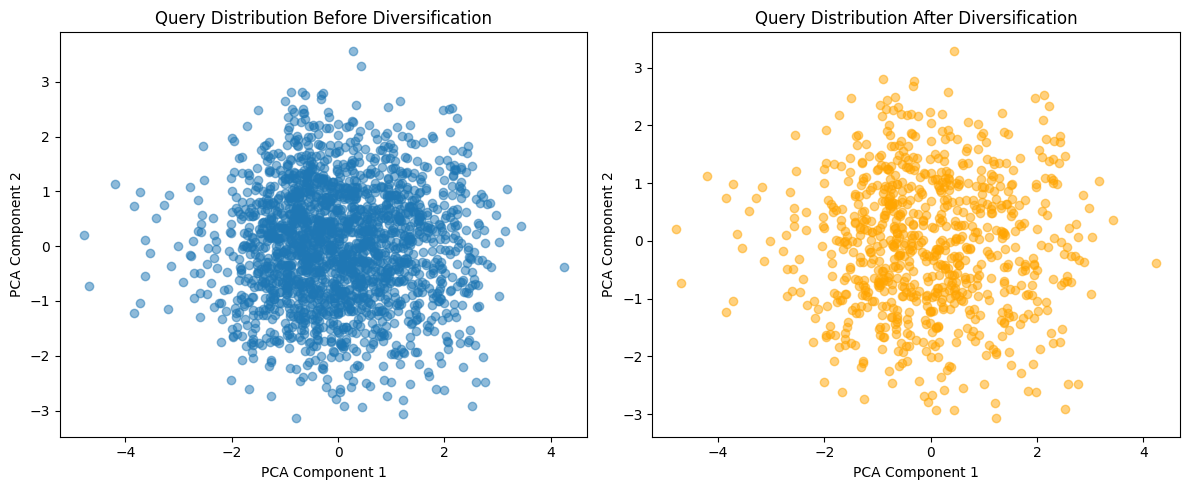

In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Function to extract features (flattened ranges + error)
def extract_features(query_log):
    features = []
    for entry in query_log:
        vec = []
        for dim in dimensions:
            lower, upper = entry['query'][dim]
            vec.extend([lower, upper])
        vec.append(entry['error'])
        features.append(vec)
    return np.array(features)

# Extract features for original and diversified
original_features = extract_features(query_log)
diversified_features = extract_features(training_data_query_log)

# Standardize
original_scaled = scaler.fit_transform(original_features)
diversified_scaled = scaler.transform(diversified_features)  # Use same scaler for consistency

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
original_pca = pca.fit_transform(original_scaled)
diversified_pca = pca.transform(diversified_scaled)  # Use same PCA

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Before diversification
axes[0].scatter(original_pca[:, 0], original_pca[:, 1], alpha=0.5)
axes[0].set_title('Query Distribution Before Diversification')
axes[0].set_xlabel('PCA Component 1')
axes[0].set_ylabel('PCA Component 2')

# After diversification
axes[1].scatter(diversified_pca[:, 0], diversified_pca[:, 1], alpha=0.5, color='orange')
axes[1].set_title('Query Distribution After Diversification')
axes[1].set_xlabel('PCA Component 1')
axes[1].set_ylabel('PCA Component 2')

plt.tight_layout()
plt.show()

Build testing data.

In [10]:
print("Generate testing...")
testing_data_query_log = []
num_queries = 100
attempts = 0
max_attempts = 1000

while len(testing_data_query_log) < num_queries and attempts < max_attempts:
    q = generate_random_query(data, dimensions)
    exact_result = exact_sum(agg_col, q, data)
    if exact_result > 0.01 * avg_exact: 
        estimate = sample_sum(agg_col, q, sample, full_data_size)
        error = exact_result - estimate
        testing_data_query_log.append({'query': q, 'exact': exact_result, 
                          'estimate': estimate, 'error': error})
    attempts += 1

avg_exact = np.mean([temp_query['exact'] for temp_query in testing_data_query_log])
print(f"Generated {len(testing_data_query_log)} testing data in {attempts} attempts")

Generate testing...
Generated 100 testing data in 100 attempts


Check training, testing data size.

In [11]:
print("Training data: ", len(training_data_query_log), "\nTesting data: ",  len(testing_data_query_log))

Training data:  800 
Testing data:  100


### Step 4: Train the Error Prediction Model

Load model if needed.

In [ ]:
import joblib

data = joblib.load("regression_pipeline.pkl")
model = data["model"]
scaler = data["scaler"]

Train model.

In [12]:
from sklearn.ensemble import RandomForestRegressor

# Input query and output x, y
def data_split(query_log):
    # Prepare features (flatten: lower/upper per dim) and targets (errors)
    X = []
    y = []
    for entry in query_log:

        vec = []
        for dim in dimensions:
            lower, upper = entry['query'][dim]
            vec.extend([lower, upper])
        X.append(vec)
        y.append(entry['error'])

    X = np.array(X)
    y = np.array(y)

    # Normalize
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y

X_train, y_train = data_split(training_data_query_log)
X_test, y_test = data_split(testing_data_query_log)

# Use max_depth = 3 as paper mentioned.
model = RandomForestRegressor(max_depth=3, random_state=42)
model.fit(X_train, y_train)

print(f"Model trained.")

# Evaluate model using MSE.
train_mse = np.mean((model.predict(X_train) - y_train) ** 2)
test_mse  = np.mean((model.predict(X_test)  - y_test)  ** 2)
print(f"Train MSE: {train_mse}")
print(f"Test  MSE: {test_mse}")


Model trained.
Train MSE: 7232083.756176003
Test  MSE: 16733069.009801777


Save model if needed.

In [13]:
import joblib

joblib.dump({
    "model": model,
    "scaler": scaler
}, "12_22.pkl")

['12_22.pkl']

### Step 5: Estimate a New Query

In [14]:
q = generate_random_query(data, dimensions, test = True)
print(q)

dim: timestamp, min value: 0.0, max value: 124515480.0
dim: Global_reactive_power, min value: 0.0, max value: 1.39
dim: Voltage, min value: 223.2, max value: 254.15
dim: Global_intensity, min value: 0.2, max value: 48.4
dim: Sub_metering_1, min value: 0.0, max value: 88.0
dim: Sub_metering_2, min value: 0.0, max value: 80.0
dim: Sub_metering_3, min value: 0.0, max value: 31.0
{'timestamp': (30174653.624079913, 119006073.08525701), 'Global_reactive_power': (0.3457027816261046, 1.3803042853547038), 'Voltage': (223.77869857130597, 253.6169368104538), 'Global_intensity': (2.8564480008171684, 43.586614011718574), 'Sub_metering_1': (9.07092403869407, 71.92971605615084), 'Sub_metering_2': (14.432212913519887, 70.03622994668899), 'Sub_metering_3': (2.5792169389533703, 27.017453791168485)}


In [15]:
# Example new 7D query (adjust ranges to sensible values based on data mins/maxes)
new_query = {
    'timestamp': (0, 80000000),  # e.g., first ~few months in seconds
    'Global_reactive_power': (0.2, 0.7),
    'Voltage': (232, 250),
    'Global_intensity': (5, 37),
    'Sub_metering_1': (0, 30),
    'Sub_metering_2': (0, 25),
    'Sub_metering_3': (0, 20)
}

# Flatten and scale
new_vec = []
for dim in dimensions:
    lower, upper = new_query[dim]
    new_vec.extend([lower, upper])
new_vec = np.array([new_vec])
new_scaled = scaler.transform(new_vec)

# Predict error
predicted_error = model.predict(new_scaled)[0]

# Find error-similar historical query (closest error)
min_diff = float('inf')
opt_entry = None
for entry in training_data_query_log:
    error_diff = abs(entry['error'] - predicted_error)
    if error_diff < min_diff:
        min_diff = error_diff
        opt_entry = entry

# Compute final estimate
sample_new = sample_sum(agg_col, new_query, sample, full_data_size)
sample_opt = opt_entry['estimate']
final_estimate = opt_entry['exact'] + (sample_new - sample_opt)

print(f"LAQP estimate: {final_estimate:.2f}")
# Compute exact for the same query (for debugging/small queries)
exact = exact_sum(agg_col, new_query, data)
print(f"Exact sum: {exact:.2f}")
print(f"Relative error: {abs(final_estimate - exact) / exact:.4f}")

# Also see how many rows match
# mask = np.ones(len(data), dtype=bool)
# for dim, (l, u) in new_query.items():
#     mask &= (data[dim] >= l) & (data[dim] <= u)
# matched_rows = mask.sum()
# print(f"Query matches {matched_rows:,} rows ({matched_rows / len(data):.1%} of dataset)")

LAQP estimate: 252587.93
Exact sum: 226848.51
Relative error: 0.1135


In [16]:
def laqp_estimate_with_details(query):
    # Flatten and predict error (same as before)
    vec = []
    for dim in dimensions:
        l, u = query[dim]
        vec.extend([l, u])
    vec = np.array([vec])
    scaled = scaler.transform(vec)
    pred_error = model.predict(scaled)[0]
    
    # Find the most error-similar historical query
    best_index = -1
    best_error_diff = float('inf')
    best_entry = None

    for idx, entry in enumerate(training_data_query_log):
        error_diff = abs(entry['error'] - pred_error)
        if error_diff < best_error_diff:
            best_error_diff = error_diff
            best_index = idx
            best_entry = entry
    
    # Compute estimates
    sample_new = sample_sum(agg_col, query, sample, full_data_size)
    sample_opt = best_entry['estimate']
    final_est = best_entry['exact'] + (sample_new - sample_opt)
    
    print(f"Selected optimal query index: {best_index} (out of  {len(training_data_query_log)})")
    print(f"Predicted error for new query: {pred_error:.2f}")
    print(f"Chosen historical query error: {best_entry['error']:.2f} (diff: {best_error_diff:.2f})")
    # print("Predicate ranges of chosen query:")
    # for dim, (l, u) in best_entry['query'].items():
    #     print(f"  {dim}: [{l:.2f}, {u:.2f}]")
    # print(f"\nFinal LAQP estimate: {final_est:.2f}")    

    return final_est, best_index, best_entry

# Use it
estimate, opt_idx, opt_entry = laqp_estimate_with_details(new_query)

Selected optimal query index: 150 (out of  800)
Predicted error for new query: 4727.28
Chosen historical query error: 4720.07 (diff: 7.21)


### Step 6: Evaluate and Extend

Optimization


In [17]:
from scipy.optimize import minimize_scalar

def range_distance(q1, q2):
    """Euclidean distance on flattened predicate bounds (for range-similarity)."""
    vec1 = []
    vec2 = []
    for dim in dimensions:
        l1, u1 = q1[dim]
        l2, u2 = q2[dim]
        vec1.extend([l1, u1])
        vec2.extend([l2, u2])
    return np.linalg.norm(np.array(vec1) - np.array(vec2))

def optimize_alpha(val_queries, model, sample, full_data_size, bounds=(0,1)):
    """
    Tune alpha for hybrid similarity (paper Section 5.3).
    val_queries: List of {'query': dict, 'exact': float} for tuning.
    Returns best alpha that minimizes average relative error on val set.
    """
    def objective(alpha):
        errors = []
        for vq in val_queries:
            query = vq['query']
            exact = vq['exact']
            
            # Predict error
            vec = [query[dim][i] for dim in dimensions for i in range(2)]
            vec = np.array([vec])
            scaled = scaler.transform(vec)
            pred_error = model.predict(scaled)[0]
            
            # Find best entry with hybrid similarity
            best_entry = min(training_data_query_log, key=lambda e: 
                alpha * abs(e['error'] - pred_error) + 
                (1 - alpha) * range_distance(query, e['query']))
            
            # LAQP estimate
            sample_new = sample_sum(agg_col, query, sample, full_data_size)
            sample_opt = best_entry['estimate']
            laqp_est = best_entry['exact'] + (sample_new - sample_opt)
            
            # Relative error
            rel_err = abs(laqp_est - exact) / (exact + 1e-6)
            errors.append(rel_err)
        
        return np.mean(errors)
    
    # Optimize alpha
    res = minimize_scalar(objective, bounds=bounds, method='bounded')
    best_alpha = res.x
    print(f"Optimized alpha: {best_alpha:.3f} (MSE on val: {res.fun:.4f})")
    return best_alpha

In [18]:
best_alpha = optimize_alpha(testing_data_query_log, model, sample, full_data_size)

# Evaluation lists
laqp_rel_errors = []
sampling_rel_errors = []
laqp_abs_errors = []
sampling_abs_errors = []
laqp_squared_errors = []
sampling_squared_errors = []

# Threshold for filtering tiny queries (adjustable)
# Good starting values: 1000 or 0.01 * average exact sum
avg_exact = np.mean([tq['exact'] for tq in testing_data_query_log])
min_exact_threshold = max(1000.0, 0.01 * avg_exact)  # at least 1000 or 1% of avg

print(f"Using minimum exact threshold: {min_exact_threshold:.2f} "
      f"(avg exact = {avg_exact:.2f})")

Optimized alpha: 0.883 (MSE on val: 0.4655)
Using minimum exact threshold: 1000.00 (avg exact = 10322.96)


In [19]:
filtered_count = 0

for tq in testing_data_query_log:
    query = tq['query']
    exact = tq['exact']
    
    if exact < min_exact_threshold:
        continue  # skip tiny queries that distort relative error
    filtered_count += 1
    
    # --- Pure Sampling Estimate ---
    sample_est = sample_sum(agg_col, query, sample, full_data_size)
    sampling_abs = abs(sample_est - exact)
    sampling_rel = sampling_abs / exact
    
    sampling_abs_errors.append(sampling_abs)
    sampling_rel_errors.append(sampling_rel)
    
    # --- LAQP Estimate ---
    # Flatten and predict error
    vec = []
    for dim in dimensions:
        l, u = query[dim]
        vec.extend([l, u])
    vec = np.array([vec])
    scaled = scaler.transform(vec)
    predicted_error = model.predict(scaled)[0]
    
    # Hybrid selection
    best_entry = min(training_data_query_log, key=lambda e: 
        best_alpha * abs(e['error'] - predicted_error) + 
        (1 - best_alpha) * range_distance(query, e['query']))
    
    # Compute estimates
    sample_new = sample_sum(agg_col, query, sample, full_data_size)
    sample_opt = best_entry['estimate']
    laqp_est = best_entry['exact'] + (sample_new - sample_opt)
    
    laqp_abs = abs(laqp_est - exact)
    laqp_rel = laqp_abs / exact
    
    laqp_abs_errors.append(laqp_abs)
    laqp_rel_errors.append(laqp_rel)

    laqp_squared = (laqp_est - exact) ** 2
    sampling_squared = (sample_est - exact) ** 2

    laqp_squared_errors.append(laqp_squared)
    sampling_squared_errors.append(sampling_squared)

# Results
print(f"Evaluated on {filtered_count} / {len(testing_data_query_log)} queries "
      f"(excluded {len(testing_data_query_log)-filtered_count} tiny ones)")

laqp_are = np.mean(laqp_rel_errors)
laqp_mse = np.mean(laqp_squared_errors)
saqp_are = np.mean(sampling_rel_errors)
saqp_mse = np.mean(sampling_squared_errors)

if len(laqp_rel_errors) > 0:
    print(f"\nLAQP ARE: {laqp_are:.4f}")
    # print(f"LAQP    Median Relative Error:       {np.median(laqp_rel_errors):.4f}")
    # print(f"LAQP    Mean Absolute Error (MAE):     {np.mean(laqp_abs_errors):.2f}")
    print(f"LAQP MSE: {laqp_mse:.2f}")
    
    print(f"\nSampling ARE: {saqp_are:.4f}")
    # print(f"Sampling Median Relative Error:     {np.median(sampling_rel_errors):.4f}")
    # print(f"Sampling MAE:                       {np.mean(sampling_abs_errors):.2f}")
    print(f"Sampling MSE: {saqp_mse:.2f}")
else:
    print("No queries passed the threshold — try lowering min_exact_threshold")

Evaluated on 100 / 100 queries (excluded 0 tiny ones)

LAQP ARE: 0.4655
LAQP MSE: 30001507.15

Sampling ARE: 0.7005
Sampling MSE: 51682099.73


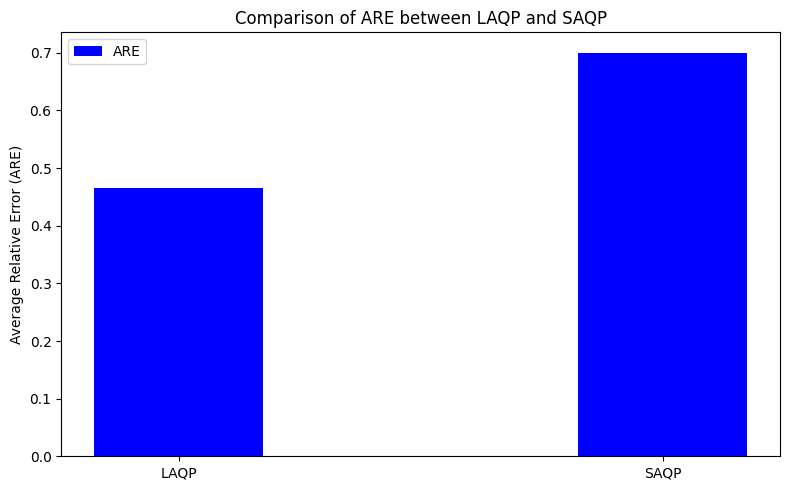

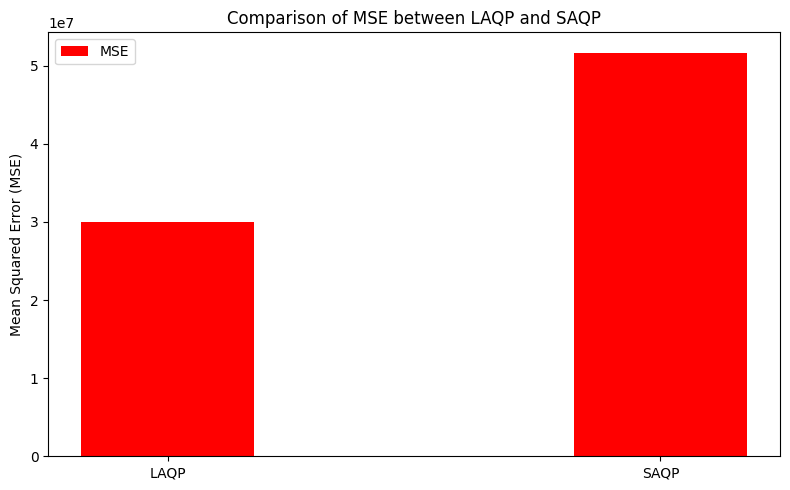

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Use your computed values (from the evaluation)
# Example placeholders based on your output; replace with actual np.mean(...) results
methods = ['LAQP', 'SAQP']
are_values = [laqp_are, saqp_are]  # From your notebook; update if re-running
mse_values = [laqp_mse, saqp_mse]  # Use the variables from above

# Bar chart for ARE
fig, ax1 = plt.subplots(figsize=(8, 5))
x = np.arange(len(methods))
width = 0.35
ax1.bar(x, are_values, width, label='ARE', color='blue')
ax1.set_ylabel('Average Relative Error (ARE)')
ax1.set_title('Comparison of ARE between LAQP and SAQP')
ax1.set_xticks(x)
ax1.set_xticklabels(methods)
ax1.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Bar chart for MSE
fig, ax2 = plt.subplots(figsize=(8, 5))
ax2.bar(x, mse_values, width, label='MSE', color='red')
ax2.set_ylabel('Mean Squared Error (MSE)')
ax2.set_title('Comparison of MSE between LAQP and SAQP')
ax2.set_xticks(x)
ax2.set_xticklabels(methods)
ax2.legend(loc='upper left')
plt.tight_layout()
plt.show()